<a href="https://colab.research.google.com/github/MuhaddidAlavi/Spanish-electric-load-forecasting-using-the-Machine-Learning-approach/blob/main/Electric_Load_Spanish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
from datetime import datetime, timedelta

import keras
import tensorflow

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Any results you write to the current directory are saved as output.
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
#load the data
data = pd.read_csv('energy_dataset.csv',index_col=[0],parse_dates=True)

dates = pd.date_range(start='2014-12-31T2300', end='2018-12-31T2200', freq='H')
data.index = pd.DatetimeIndex(dates).tz_localize('UTC').tz_convert('Europe/Madrid')
df = data[['total load actual', 'total load forecast']]

null_vals = df.isnull().sum()
print('Null values in the target column {}'.format(null_vals))
df.head()

Null values in the target column total load actual      36
total load forecast     0
dtype: int64


,total load actual,total load forecast
2015-01-01 00:00:00+01:00,25385.0,26118.0
2015-01-01 01:00:00+01:00,24382.0,24934.0
2015-01-01 02:00:00+01:00,22734.0,23515.0
2015-01-01 03:00:00+01:00,21286.0,22642.0
2015-01-01 04:00:00+01:00,20264.0,21785.0


In [ ]:
df.index.min(), df.index.max()

(Timestamp('2015-01-01 00:00:00+0100', tz='Europe/Madrid', freq='H'),
 Timestamp('2018-12-31 23:00:00+0100', tz='Europe/Madrid', freq='H'))

In [ ]:
df = df.interpolate(method='linear', axis=0)
df.isnull().sum()

total load actual      0
total load forecast    0
dtype: int64

In [ ]:
def transform_to_hour_cols(series):
    df = pd.DataFrame()

    start = series.index.min()
    end = series.index.max()
    
    df['year'] = series.index.year
    df['month'] = series.index.month
    df['day'] = series.index.day
    df['hours'] = series.index.hour
    df['loads'] = series.values
    
    df = df.set_index(['year', 'month', 'day', 'hours'], append=True).unstack()
    df = df.groupby(['year', 'month', 'day']).sum()
    
    df.reset_index(inplace=True)
    df.drop(['year', 'month', 'day'], axis=1, inplace=True)
    
    date_list = pd.date_range(start=start, end=end, freq='D').strftime('%Y-%m-%d')
    
    df.index = pd.DatetimeIndex(date_list, name='date')
    
    return df

day_energy = transform_to_hour_cols(df['total load actual'])
day_energy.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


loads                                                                                                                                                                                                               
hours            0        1        2        3        4        5        6        7        8        9        10       11       12       13       14       15       16       17       18       19       20       21       22       23
date                                                                                                                                                                                                                              
2015-01-01  25385.0  24382.0  22734.0  21286.0  20264.0  19905.0  20010.0  20377.0  20094.0  20637.0  22250.0  23547.0  24133.0  24713.0  24672.0  23528.0  23118.0  23606.0  26447.0  28020.0  29014.0  29571.0  29031.0  26798.0
2015-01-02  27070.0  24935.0  23214.0  22540.0  22096.0  22066.0  22275.0  23025.0  23699.0  25834.0  27927.0  29072.0  29071.0  29439.0  29241.0  27973.0  27320.0  27157.0  29045.0  31967.0  33266.0  33668.0  32426.0  29705.0
2015-01-03  25564.0  23584.0  22194.0  21296.0  21145.0  21316.0  21674.0  22127.0  22756.0  24654.0  26454.0  26959.0  26716.0  26802.0  26416.0  25362.0  24770.0  24501.0  24992.0  27964.0  29694.0  29874.0  28979.0  26863.0
2015-01-04  25254.0  23620.0  22606.0  22191.0  21929.0  22195.0  24035.0  26807.0  28316.0  29871.0  30585.0  30772.0  30685.0  30429.0  28741.0  28249.0  28105.0  27908.0  27577.0  27418.0  28604.0  30346.0  28190.0  26270.0
2015-01-05  25069.0  23390.0  21988.0  21182.0  20778.0  20309.0  20252.0  19964.0  20796.0  22478.0  23834.0  24429.0  24066.0  23703.0  23340.0  22977.0  22614.0  22251.0  21888.0  22048.0  22858.0  25604.0  25381.0  23822.0

In [ ]:
#make life easier
day_energy.columns = ["h"+ str(x) for x in range(0, 24)]

#get dates for dailight savings times
idx = day_energy.loc[day_energy['h2']==0, 'h2'].index

#set values zero values to NaN
day_energy.loc[day_energy['h2']==0, 'h2'] = np.NaN

day_energy.loc[idx, 'h2']

date
2015-03-29   NaN
2016-03-27   NaN
2017-03-26   NaN
2018-03-25   NaN
Name: h2, dtype: float64

In [ ]:
day_energy = day_energy.interpolate(method='linear', axis=0)
day_energy.loc[idx, 'h2']

date
2015-03-29    22415.5
2016-03-27    20984.0
2017-03-26    23052.5
2018-03-25    24388.0
Name: h2, dtype: float64

[]

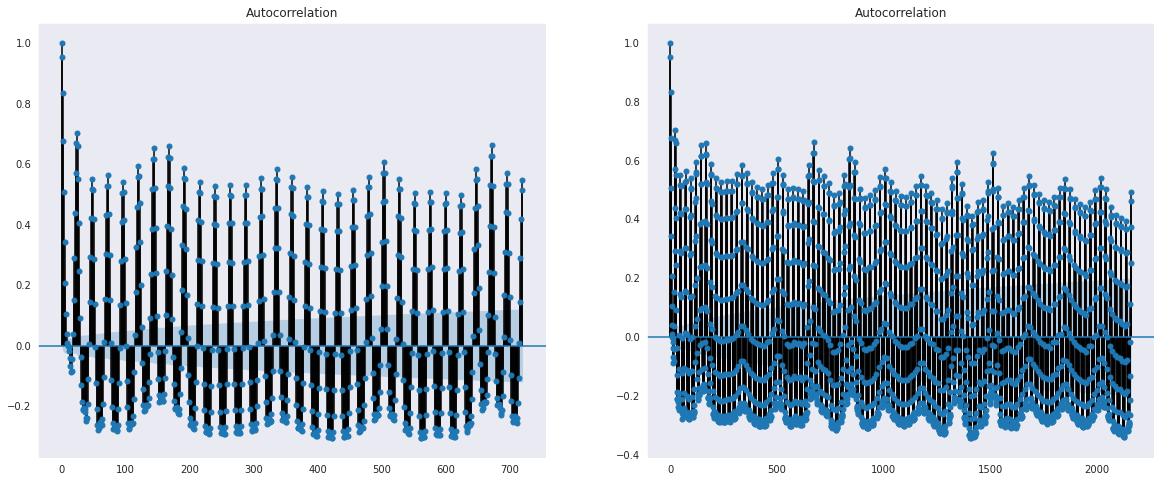

In [ ]:
#isolate the original series of demand data
energy_demand_univar = df['total load actual']

fig, axs = plt.subplots(1,2, figsize=(20,8))

#we will plot the last 30 and 90 days
lags = [30*24, 90*24]

for ax, lag in zip(axs.flatten(), lags):
    plot_acf(energy_demand_univar, ax=ax, lags=lag)
plt.plot()

[]

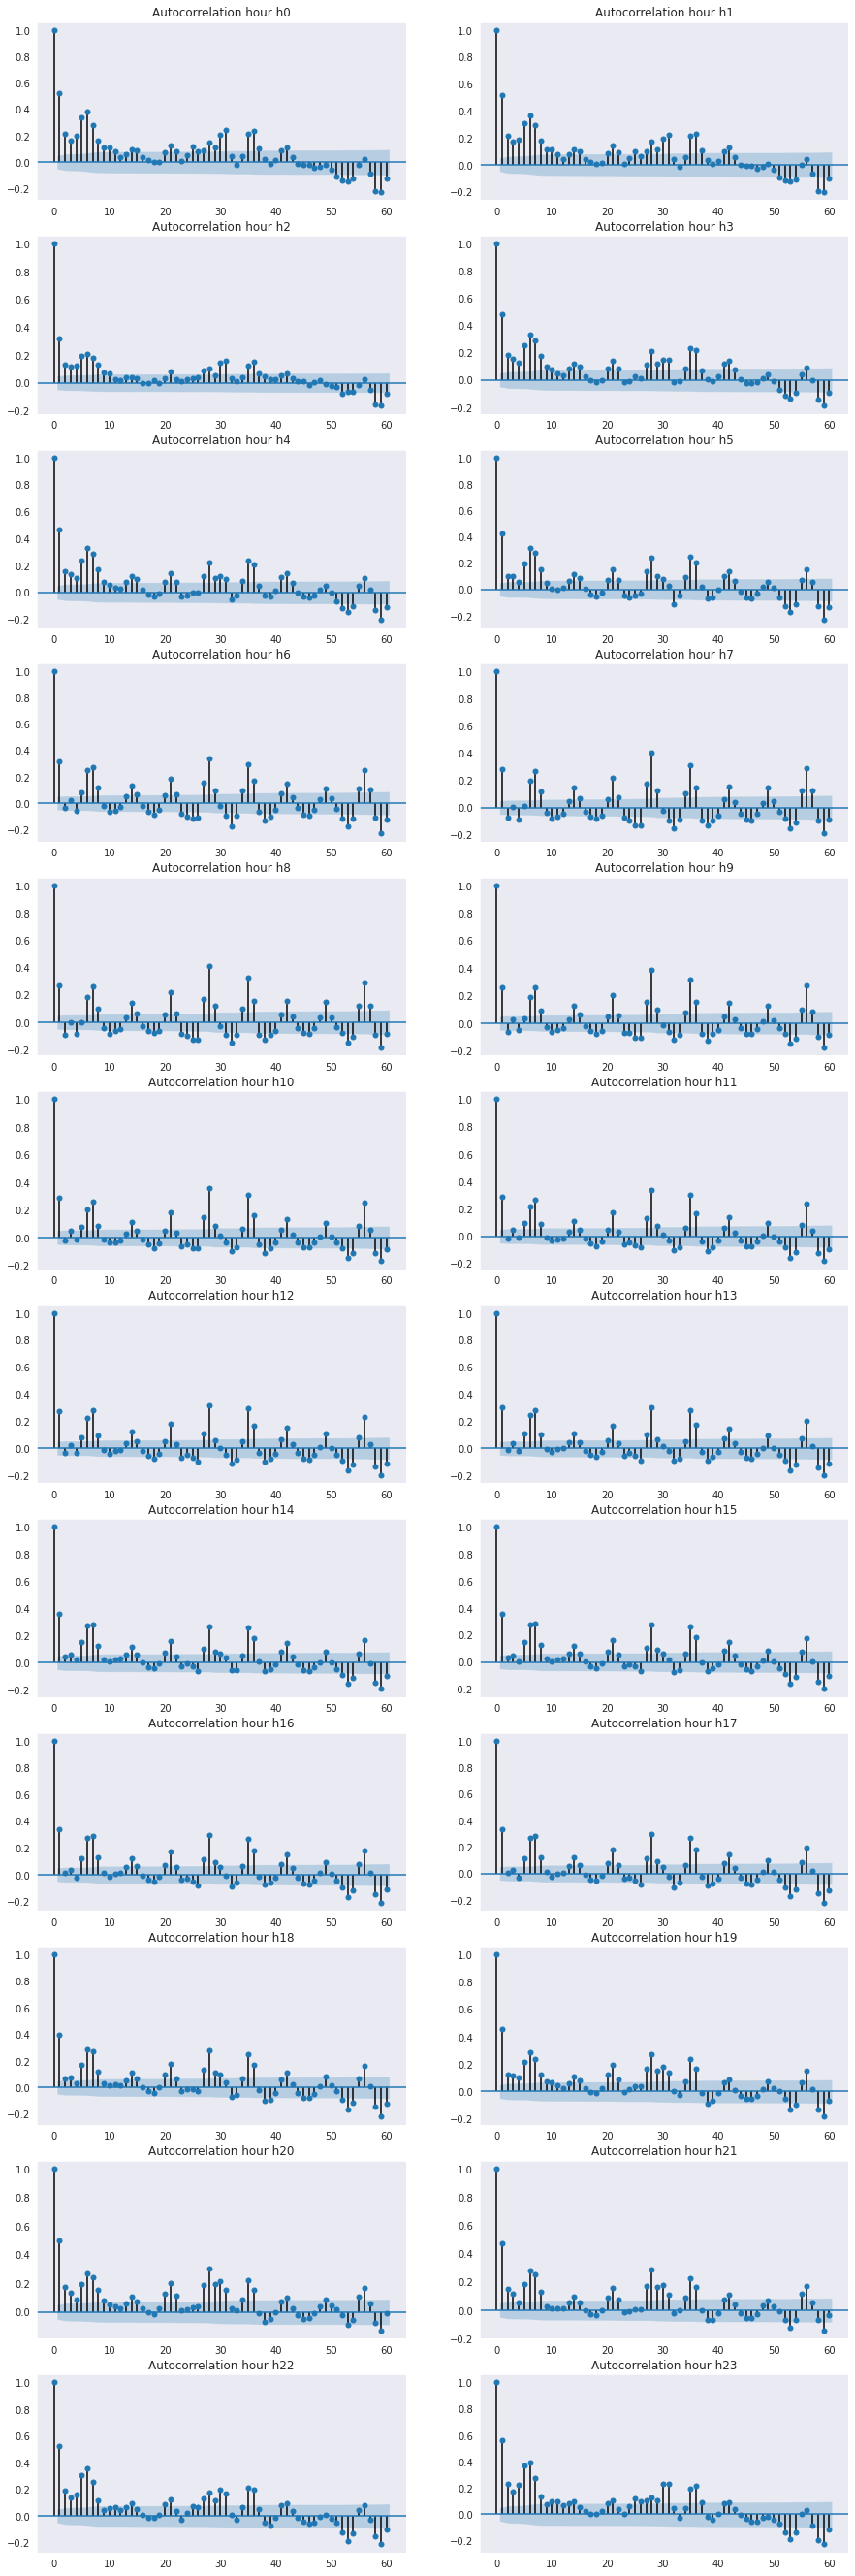

In [ ]:
plots = len(day_energy.columns)
fig, axs = plt.subplots(int(plots/2), 2, figsize=(15, 2*plots))

for hour, ax in zip(day_energy.columns, axs.flatten()):
        plot_acf(day_energy.loc[:,hour], ax=ax, lags=60)
        ax.set_title('Autocorrelation hour ' + str(hour))
plt.plot()

[]

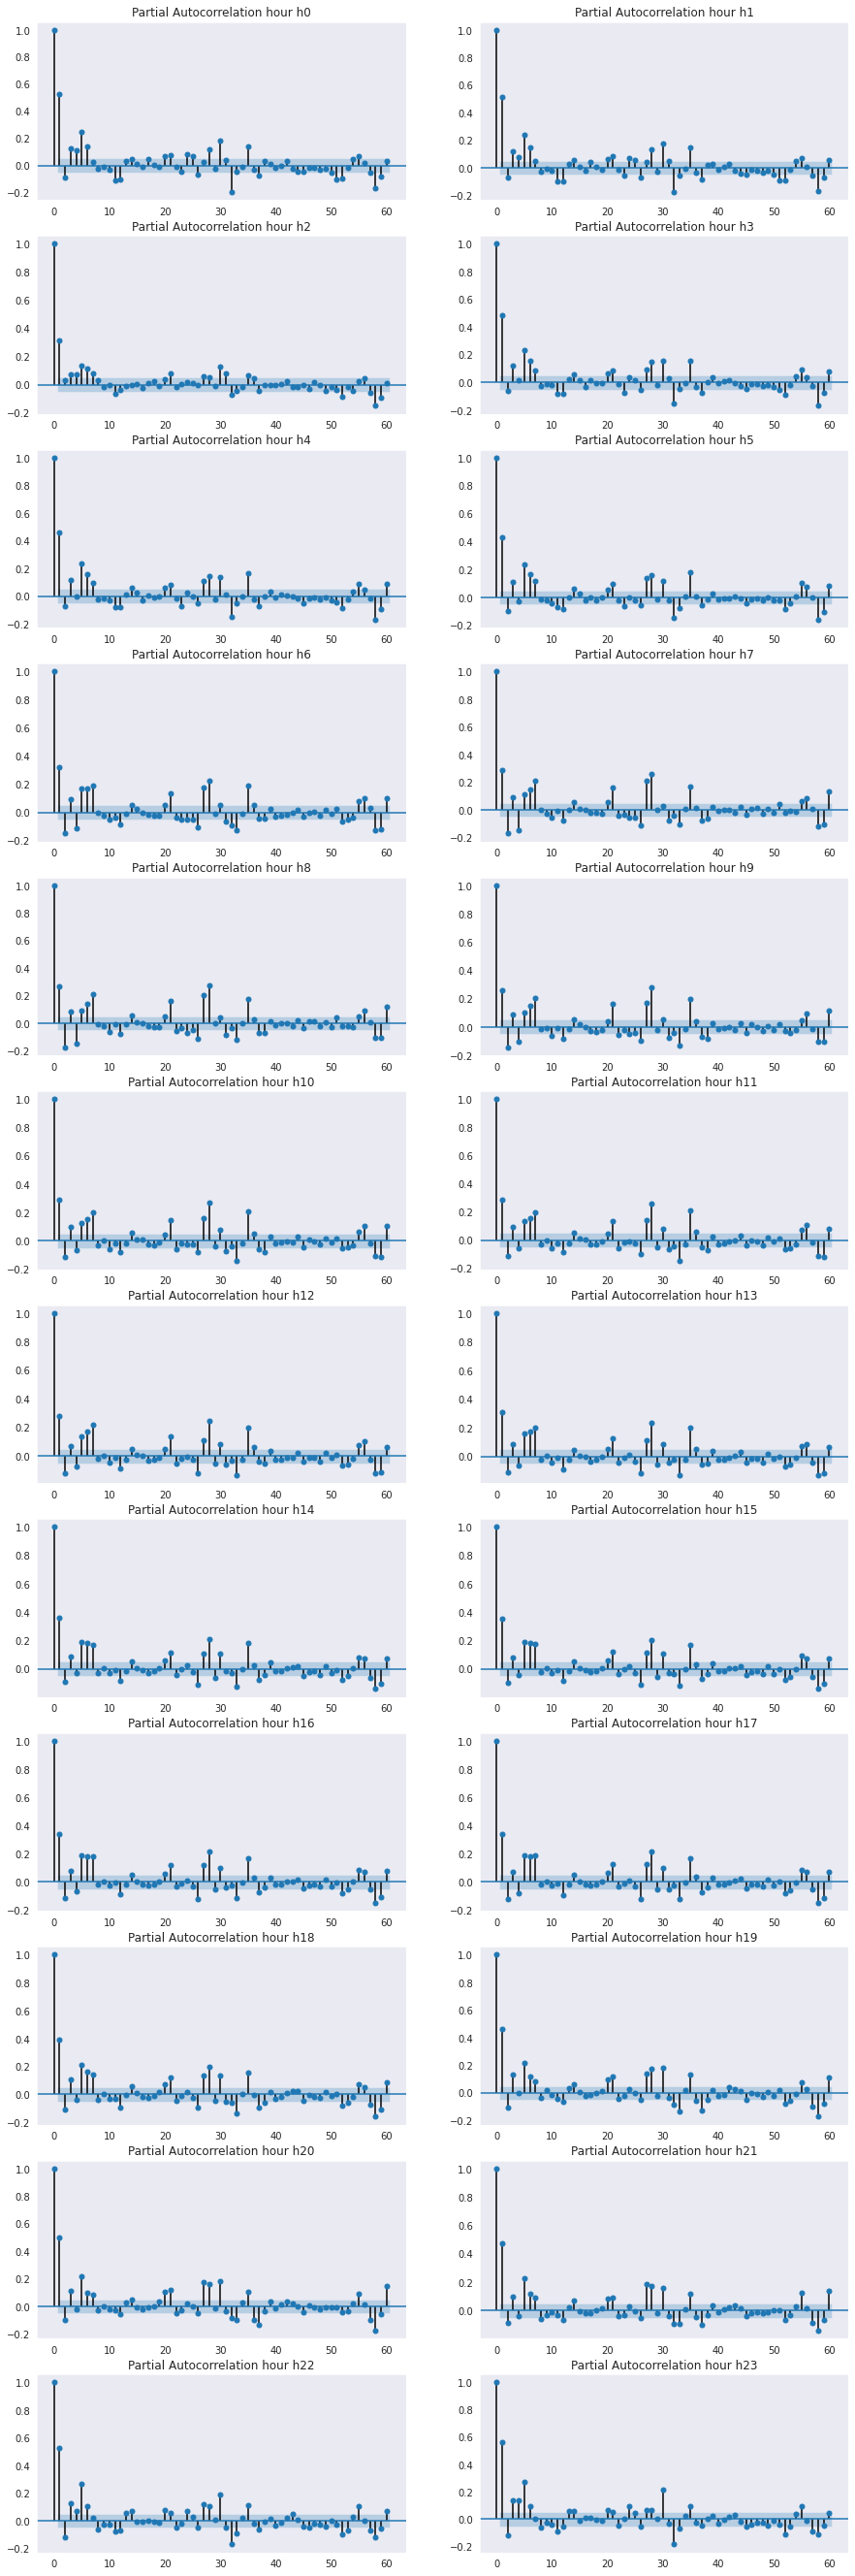

In [ ]:
plots = len(day_energy.columns)
fig, axs = plt.subplots(int(plots/2), 2, figsize=(15, 2*plots))

for hour, ax in zip(day_energy.columns, axs.flatten()):
        plot_pacf(day_energy.loc[:,hour], ax=ax, lags=60)
        ax.set_title('Partial Autocorrelation hour ' + str(hour))
plt.plot()

In [ ]:
def normalize_df(data):
    
    #normalize the dataset for working with the lstm nn
    scaler = MinMaxScaler().fit(data.values)
    data_normd = scaler.transform(data.values)
    
    #return as dataframe
    data = pd.DataFrame(data_normd, index=data.index, columns=data.columns)
    
    return data, scaler

In [ ]:
#normalize the energy dataframe
day_energy_normed, scaler = normalize_df(day_energy)

In [ ]:
def split_sequences(sequences, n_steps, extra_lag=False, long_lag_step=7, max_step=30, idx=0, multivar=False):
    """
    Modified based on content by Jason Brownlee from MachineLearningMastery.
    
    n_step - is the number of consecutive past steps from the target day to construct
    long_lag_step - is the size of the trailing lag beyond the n_steps. Ie. if n_steps is 3, and long_lag_step is 7 will return day -1, -2, -3, -7, -14 etc to max_step
    idx - is the starting index for the first slice
    multivari - true if the input data has multiple variable structure. false for univariate
    """
    
    #if not adding extra lag features adjust max_step and n_steps to aling
    if not extra_lag:
        max_step=n_steps
        n_steps+=1
        
    
    X, y = list(), list()
    for i in range(len(sequences)):
        
        # find the end of this pattern
        #end_ix = i + n_steps
        end_ix = i + max_step
        
        #create a list with the indexes we want to include in each sample
        slices = [x for x in range(end_ix-1,end_ix-n_steps, -1)] + [y for y in range(end_ix-n_steps, i, -long_lag_step)]
        
        #reverse the slice indexes
        slices = list(reversed(slices))
        
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break


        # gather input and output parts of the pattern
        seq_x = sequences[slices, :]
        seq_y = sequences[end_ix, :]

        X.append(seq_x)
        y.append(seq_y)
        
    X = np.array(X)
    y = np.array(y)
    
    if multivar:
        #unstack the 3rd dimension and select the first element(energy load)
        y = y[:,idx]
    
    return X, y

In [ ]:
#create the supervised learning problem
n_steps = 21

X, Y = split_sequences(day_energy_normed.values, n_steps, extra_lag=True, long_lag_step=7, max_step=60, idx=0, multivar=False)
print(X.shape, Y.shape)
X[:5], Y[:5]

(1401, 26, 24) (1401, 24)


(array([[[0.3370004 , 0.32305783, 0.13480312, ..., 0.04953395,
          0.10132293, 0.07479675],
         [0.54047235, 0.51774077, 0.23443412, ..., 0.72989348,
          0.67874895, 0.63653754],
         [0.51826807, 0.45339816, 0.1963193 , ..., 0.88029294,
          0.85057735, 0.82046868],
         ...,
         [0.57872426, 0.56977346, 0.25475267, ..., 0.59134487,
          0.60472585, 0.63749402],
         [0.60647961, 0.55632564, 0.2303237 , ..., 0.38508655,
          0.42563279, 0.44466762],
         [0.55641906, 0.46094962, 0.17558036, ..., 0.53362184,
          0.57169075, 0.60506934]],
 
        [[0.19993944, 0.21588911, 0.1141576 , ..., 0.39194407,
          0.45285616, 0.41903396],
         [0.6361526 , 0.56718734, 0.25293101, ..., 0.79700399,
          0.75827789, 0.73582018],
         [0.73627372, 0.64218475, 0.27955533, ..., 0.95525965,
          0.93308863, 0.91142994],
         ...,
         [0.60647961, 0.55632564, 0.2303237 , ..., 0.38508655,
          0.42563279, 0.

In [ ]:
###define an LSTM model
#takes in parallel inputs and outputs an equal number of parallel outputs
def lstm_parallel_out(n_lags, n_hours, cells=50, learning_rate=5e-3):
    
    #define the model
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(cells, activation='relu', return_sequences=True, input_shape=(n_lags, n_hours)))
    model.add(keras.layers.LSTM(int(cells/2), activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(n_hours))
    
    #define the learning rate
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    
    #compile model
    model.compile(optimizer=optimizer, loss='mae')
    
    return model

In [ ]:
def crossval_testbench(X, y, n_crossvals, epochs=5, verbose=0):
    
    n_hours = X.shape[-1]
    n_features = X.shape[1]
    
    tscv = TimeSeriesSplit(n_splits=n_crossvals)

    #initalize lists to capture the output
    predictions = []
    actuals = []


    #run the LSTM model on each of the time series splits
    for train, test in tscv.split(X, y):
        
        #initalize the lstm model
        lstm_base = lstm_parallel_out(n_features, n_hours, learning_rate=5e-3)
        
        #fit the model
        lstm_base.fit(X[train], y[train], epochs=epochs, verbose=verbose, shuffle=False)
        
        #make predictions
        predict = lstm_base.predict(X[test], verbose=verbose)


        #inverse transform the predictions and actual values
        prediction = scaler.inverse_transform(predict)
        actual = scaler.inverse_transform(y[test].copy())

        #save the results in a list
        predictions.append(prediction)
        actuals.append(actual)
        
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    return predictions, actuals

In [ ]:
preds, actuals = crossval_testbench(X, Y, 2, epochs=150, verbose=1)

Epoch 1/150
15/15 [==============================] - 0s 22ms/step - loss: 0.3298
Epoch 2/150
15/15 [==============================] - 0s 22ms/step - loss: 0.2062
Epoch 3/150
15/15 [==============================] - 0s 22ms/step - loss: 0.1795
Epoch 4/150
15/15 [==============================] - 0s 21ms/step - loss: 0.1684
Epoch 5/150
15/15 [==============================] - 0s 23ms/step - loss: 0.1625
Epoch 6/150
15/15 [==============================] - 0s 22ms/step - loss: 0.1594
Epoch 7/150
15/15 [==============================] - 0s 21ms/step - loss: 0.1606
Epoch 8/150
15/15 [==============================] - 0s 23ms/step - loss: 0.1607
Epoch 9/150
15/15 [==============================] - 0s 23ms/step - loss: 0.1561
Epoch 10/150
15/15 [==============================] - 0s 23ms/step - loss: 0.1530
Epoch 11/150
15/15 [==============================] - 0s 23ms/step - loss: 0.1551
Epoch 12/150
15/15 [==============================] - 0s 23ms/step - loss: 0.1495
Epoch 13/150
15/15 [=====

In [ ]:
preds.shape, actuals.shape

((2, 467, 24), (2, 467, 24))

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
#MAPE for a specific hour
error_h0 = mean_absolute_percentage_error(actuals[0,:5,0], preds[0, :5,0])
print(f'MAPE for Hour 0: {round(error_h0, 2)}')

MAPE for Hour 0: 3.8


In [ ]:
crossvals = actuals.shape[0]
hours = actuals.shape[2]

errors_crossvals = list()
for crossval in range(crossvals):
    errors_hourly = [mean_absolute_percentage_error(actuals[crossval, :, hour], preds[crossval, :, hour]) for hour in range(hours)]
    errors_crossvals.append(errors_hourly)
    
errors = pd.DataFrame(errors_crossvals)
errors['mean'] = errors.mean(axis=1)
errors.index.name='crossval set'
errors.columns.name='hours'
errors

hours,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,mean
crossval set,,,,,,,,,,,,,,,,,,,,,,,,,
0,4.606709,4.667593,4.826559,4.700432,4.678321,4.780262,6.388204,10.197079,11.690932,10.368926,8.65653,7.982980,7.825751,7.694722,7.380311,8.060729,8.727645,8.863901,8.561109,8.234790,7.852531,6.049968,5.224374,5.014419,7.209782
1,4.090188,3.851826,4.087250,3.865709,3.933997,4.190230,5.686171,8.579366,9.280167,7.994297,6.83620,6.353558,6.504149,6.312042,6.094205,6.797422,7.348376,7.458096,7.347538,7.014647,6.375272,5.161210,4.814951,4.453072,6.017914


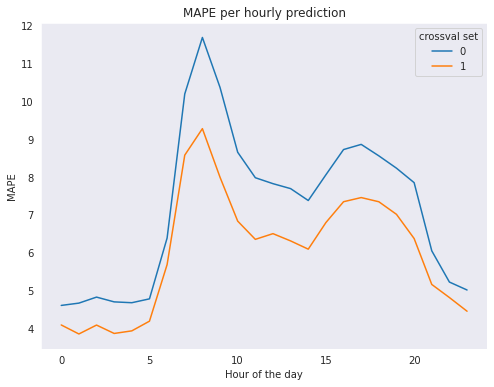

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(errors.drop(columns='mean').T)
plt.title('MAPE per hourly prediction')
plt.legend(errors.index, title='crossval set')
plt.xlabel('Hour of the day')
plt.ylabel('MAPE')
plt.show()

In [ ]:
def train_test_split(df, split_date):
    
    
    train_date = pd.Timestamp(split_date).strftime('%Y-%m-%d')
    test_date = (pd.Timestamp(split_date) + timedelta(1)).strftime('%Y-%m-%d')
    
    df_train = df[:train_date]
    df_test = df[test_date:]
    
    return df_train, df_test

train, test = train_test_split(day_energy, '2017-12-31')

print(f'Training start date {train.index.min()} end date {train.index.max()}')
print(f'Training start date {test.index.min()} end date {test.index.max()}')

Training start date 2015-01-01 00:00:00 end date 2017-12-31 00:00:00
Training start date 2018-01-01 00:00:00 end date 2018-12-31 00:00:00


In [ ]:
train_norm, scalar = normalize_df(train)
test_norm = scalar.transform(test)

#create the supervised learning problem
n_steps = 21

X_train, Y_train = split_sequences(train_norm.values, n_steps, extra_lag=True, long_lag_step=7, max_step=60, idx=0, multivar=False)

print(f'Training Set X {X_train.shape} and Y {Y_train.shape}')

Training Set X (1036, 26, 24) and Y (1036, 24)


In [ ]:
test_set = np.vstack([train_norm.values[-60:], test_norm])
print(f'Dimensions of the test set with training data needed for predictions: {test_set.shape}')

X_test, Y_test = split_sequences(test_set, n_steps, extra_lag=True, long_lag_step=7, max_step=60, idx=0, multivar=False)

print(f'Testing Set X {X_test.shape} and Y {Y_test.shape}')

Dimensions of the test set with training data needed for predictions: (425, 24)
Testing Set X (365, 26, 24) and Y (365, 24)


In [ ]:
n_features=X_train.shape[1]
n_hours=X_train.shape[2]
#initalize the lstm model
lstm_eval = lstm_parallel_out(n_features, n_hours, learning_rate=5e-3)
        
#fit the model
lstm_eval.fit(X_train, Y_train, epochs=350, verbose=1, shuffle=False)
        
#check predictions on the train set
train_predictions = lstm_eval.predict(X_train, verbose=1)

#run predictions on test data
test_predictions = lstm_eval.predict(X_test, verbose=1)

Epoch 1/350
33/33 [==============================] - 1s 22ms/step - loss: 0.2820
Epoch 2/350
33/33 [==============================] - 1s 22ms/step - loss: 0.1770
Epoch 3/350
33/33 [==============================] - 1s 22ms/step - loss: 0.1641
Epoch 4/350
33/33 [==============================] - 1s 22ms/step - loss: 0.1587
Epoch 5/350
33/33 [==============================] - 1s 21ms/step - loss: 0.1537
Epoch 6/350
33/33 [==============================] - 1s 22ms/step - loss: 0.1525
Epoch 7/350
33/33 [==============================] - 1s 22ms/step - loss: 0.1470
Epoch 8/350
33/33 [==============================] - 1s 22ms/step - loss: 0.1488
Epoch 9/350
33/33 [==============================] - 1s 22ms/step - loss: 0.1461
Epoch 10/350
33/33 [==============================] - 1s 22ms/step - loss: 0.1431
Epoch 11/350
33/33 [==============================] - 1s 22ms/step - loss: 0.1406
Epoch 12/350
33/33 [==============================] - 1s 25ms/step - loss: 0.1381
Epoch 13/350
33/33 [=====

In [ ]:
train_preds = scalar.inverse_transform(train_predictions)
test_preds = scalar.inverse_transform(test_predictions)
Y_train = scalar.inverse_transform(Y_train)
Y_test = scalar.inverse_transform(Y_test)

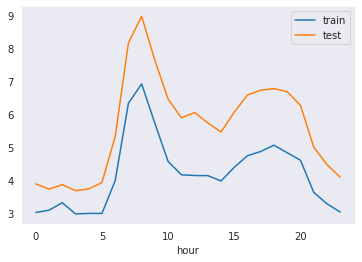

In [ ]:
train_error = pd.DataFrame([mean_absolute_percentage_error(Y_train[:, hour], train_preds[:, hour]) for hour in range(hours)], columns=['train'])
test_error = pd.DataFrame([mean_absolute_percentage_error(Y_test[:, hour], test_preds[:, hour]) for hour in range(hours)], columns=['test'])

errors = pd.concat([train_error, test_error], axis=1)
errors.index.name = 'hour'
errors.plot()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the ear

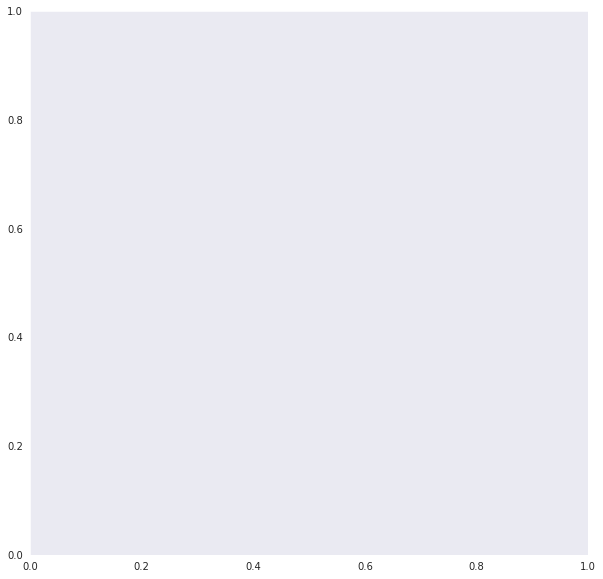

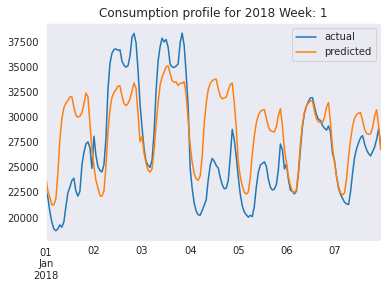

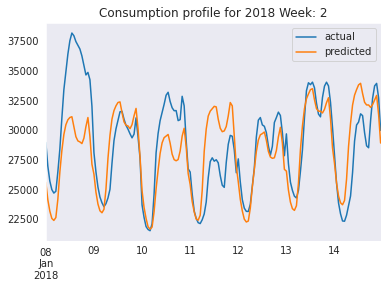

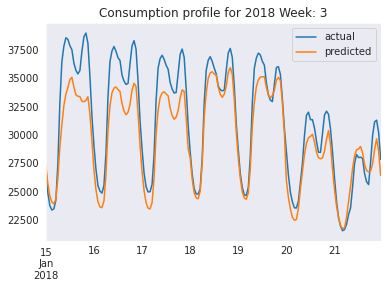

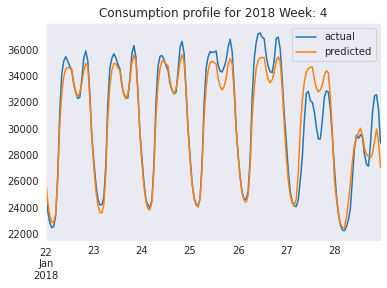

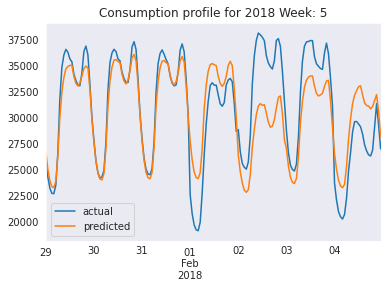

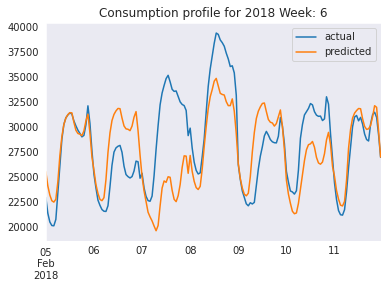

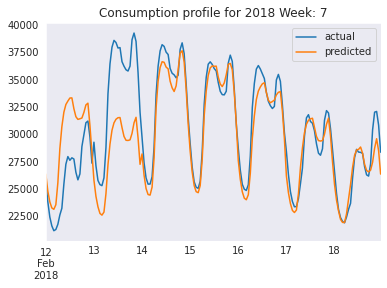

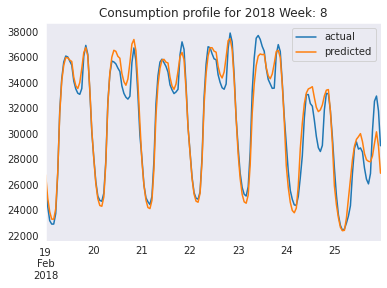

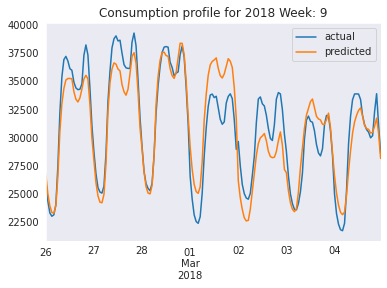

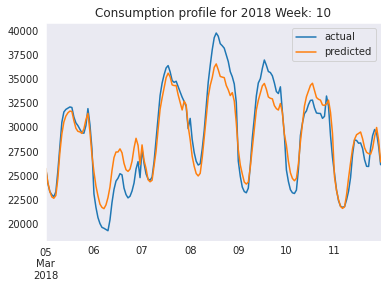

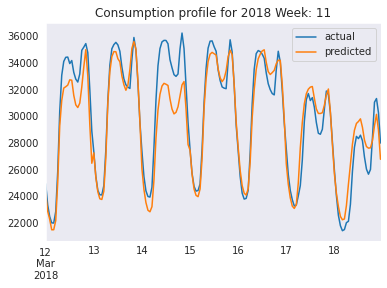

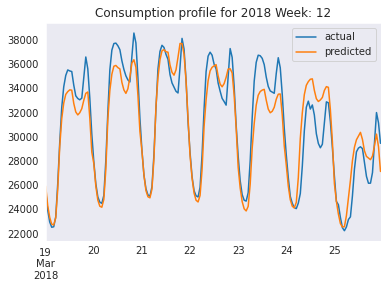

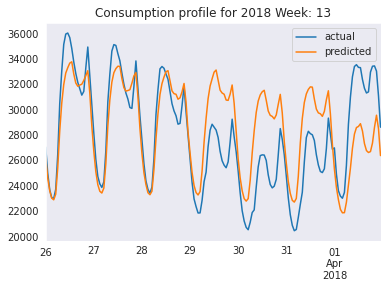

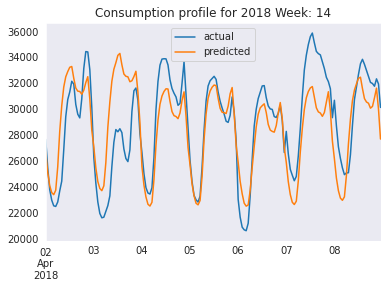

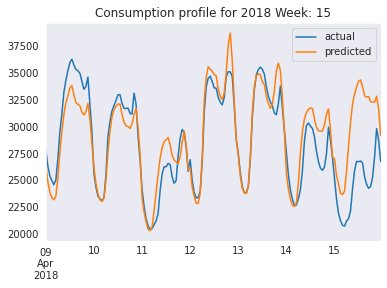

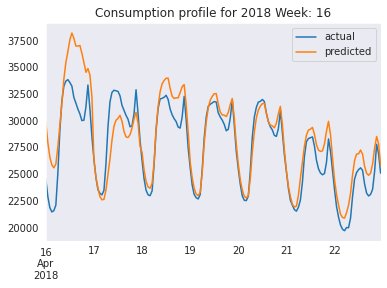

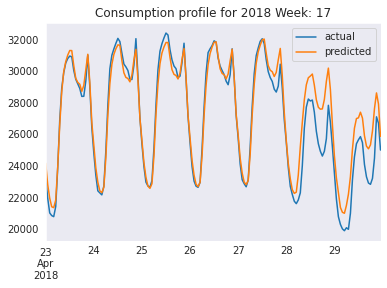

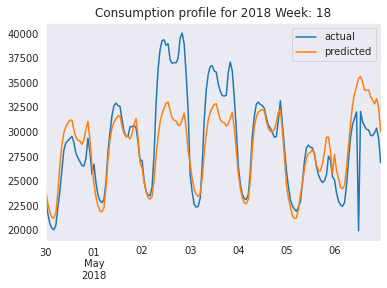

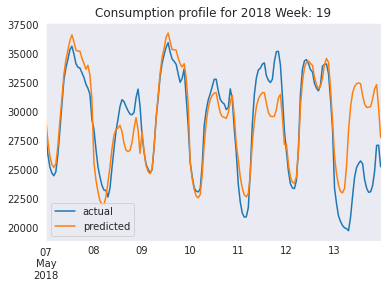

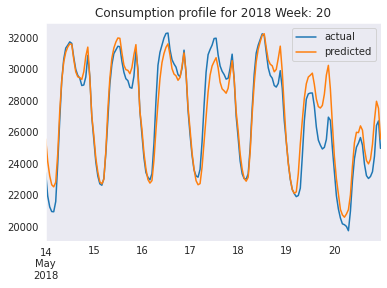

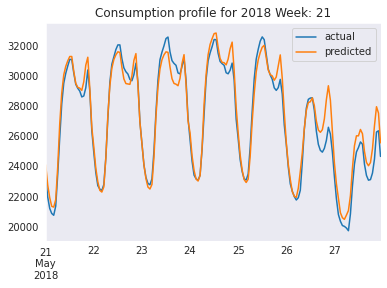

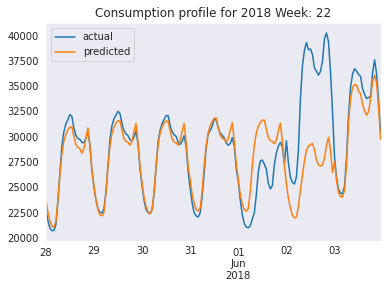

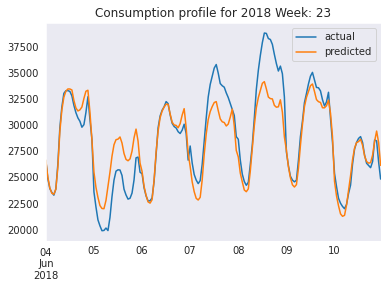

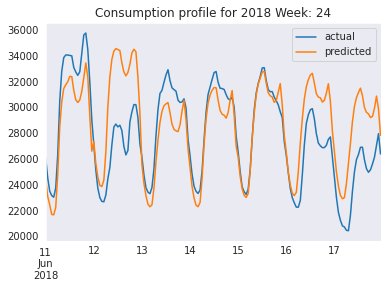

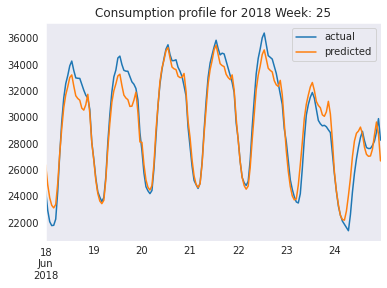

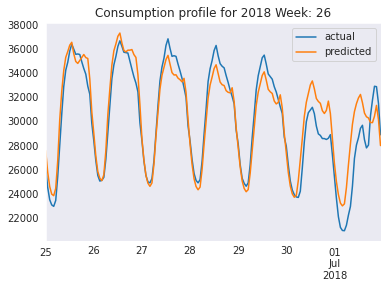

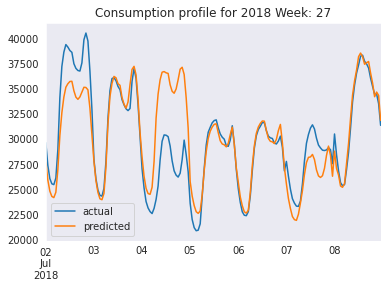

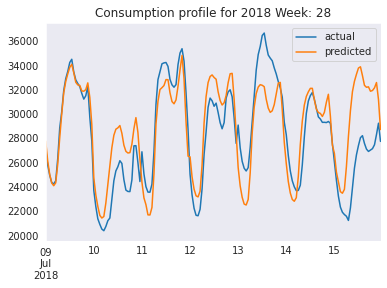

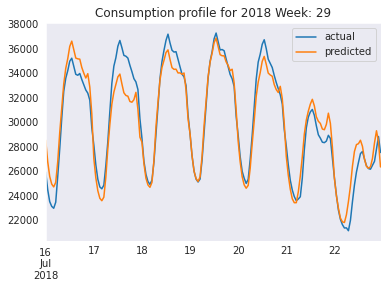

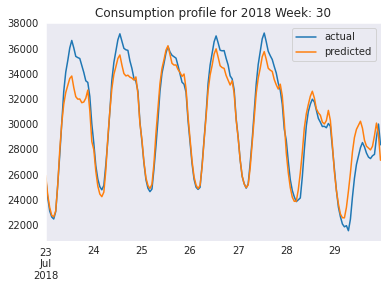

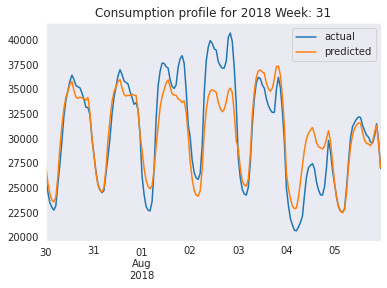

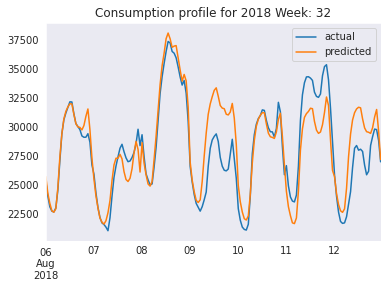

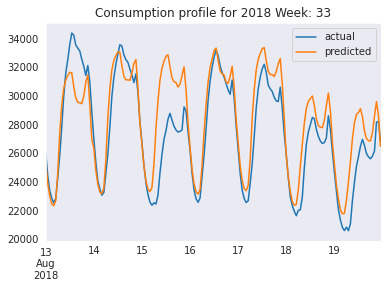

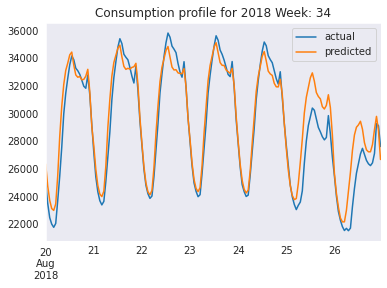

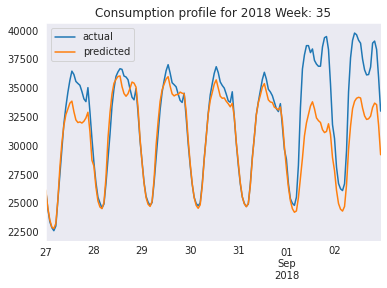

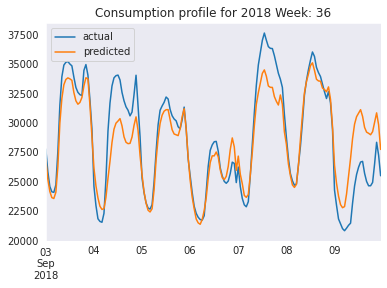

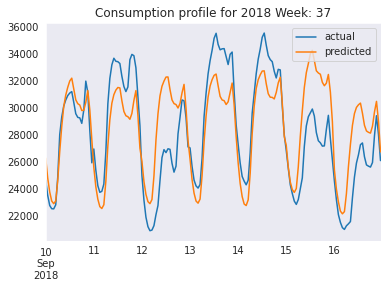

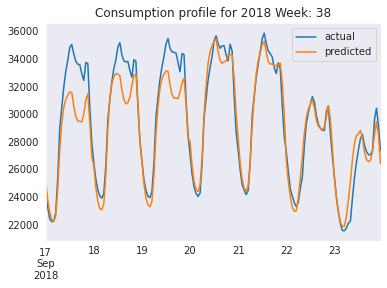

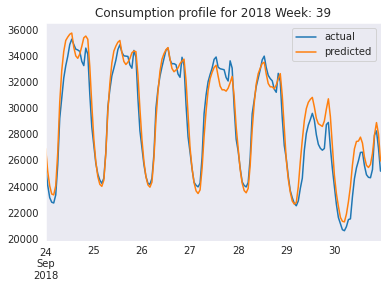

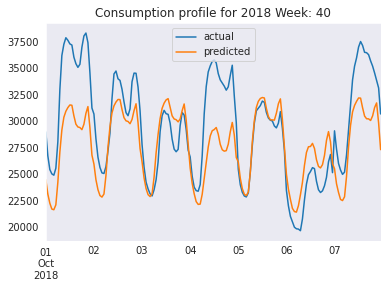

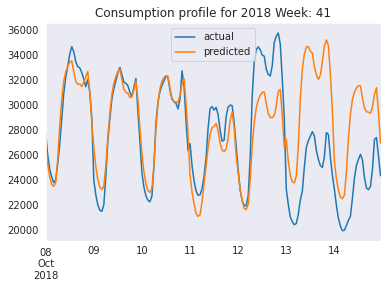

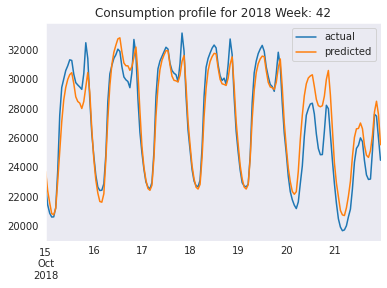

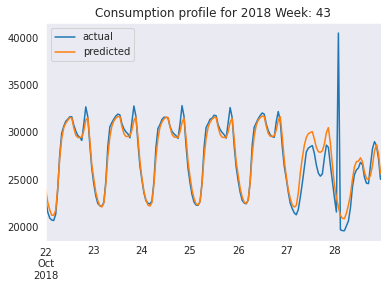

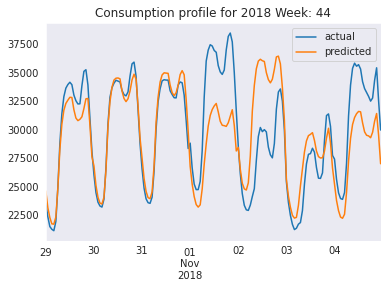

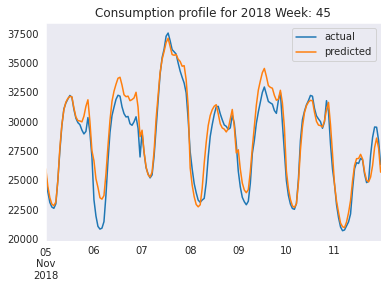

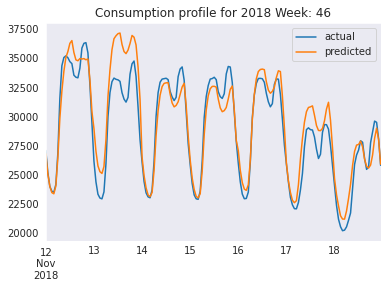

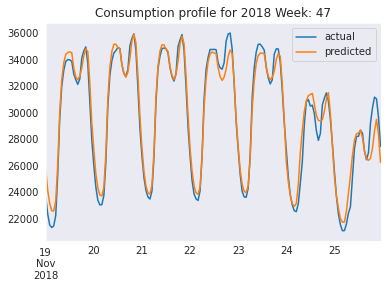

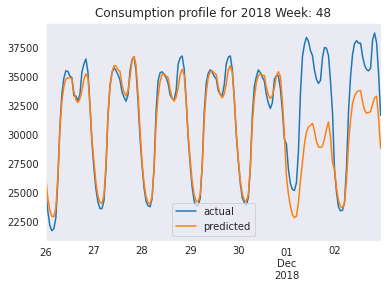

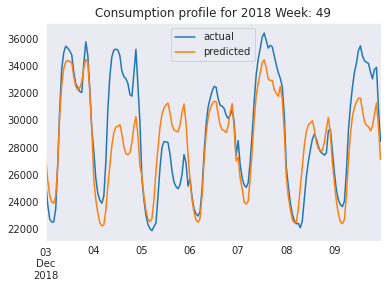

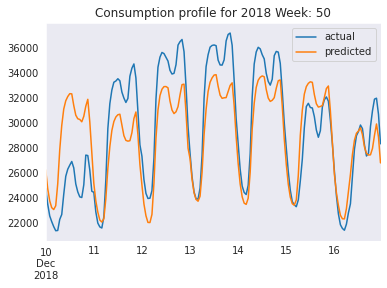

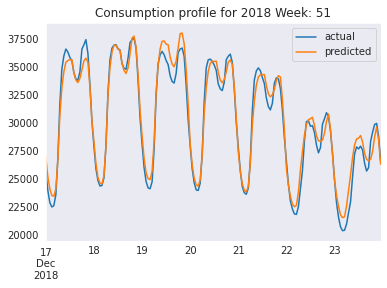

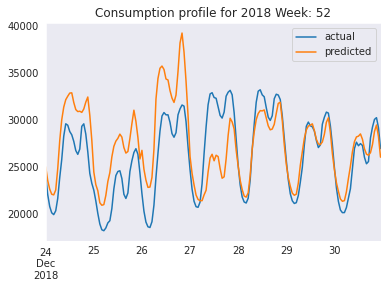

In [ ]:
test_df = pd.DataFrame(test_preds).stack()
Y_test_df = pd.DataFrame(Y_test).stack()

preds_df = pd.concat([Y_test_df, test_df], axis=1)
preds_df.columns = ['actual', 'predicted']

preds_df.index = pd.DatetimeIndex(pd.date_range(start='2018-01-01T0000', end='2018-12-31T2300', freq='H'))

fig = plt.figure(figsize=(10,10))

for week in range(52):

    fig.add_subplot()
    preds_df.iloc[week*7*24:(week+1)*7* 24].plot()
    plt.title(f'Consumption profile for 2018 Week: {week+1}')